In [42]:
import numpy as np
import networkx as nx
import pandas as pd
import os
from matplotlib import pyplot as plt

import enzope

datapath = '/home/lautaro/Workspace/ib/code/codedoc/realdata/redes/FAO'

## 09/10: Primer paso, dataset (nombres + coordenadas)

In [43]:
# Paso de latitud/longitud a coordenadas x, y en la proy. Mercator (en km)
def merc_from_arrays(lats, lons):
    # Voy a usar como unidad de longitud 1 km (10^3 m)
    r_major = 6378.137000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return np.vstack((x, y)).T

In [44]:
# Voy a armar y guardar el dataset de nodos con los datos de latitud/longitud
coords = pd.read_csv(os.path.join(datapath, 'coordinate-countries-fixed.csv'))
coords = coords.rename(columns={'ISO 3166 Country Code': 'Code'})
coordinates = merc_from_arrays(coords['Latitude'], coords['Longitude'])
coords['x'] = coordinates[:, 0]
coords['y'] = coordinates[:, 1]

# Dropeo Hong Kong, Taiwan, China mainland y Macao
coords = coords[coords['Country'] != 'Hong Kong']
coords = coords[coords['Country'] != 'Taiwan']
coords = coords[coords['Country'] != 'China, mainland']
coords = coords[coords['Country'] != 'Macao']

# El codigo de Namibia se rompe
coords.loc[coords['Country'] == 'Namibia', 'Code'] = 'NAM'

nodes = pd.read_csv(os.path.join(datapath, 'nodes-fixed.csv'))
nodes = nodes.rename(columns={'# index': 'index', ' name': 'name'})
nodes = nodes.drop(columns=[' nodeLabel', ' _pos'])
# Drop row from nodes where 'Name' is 'unspecified'
nodes = nodes[nodes['name'] != 'Unspecified']
# Reemplazo '_' con ' ' para que matcheen mas paises
nodes['name'] = nodes['name'].str.replace('_', ' ')

# Merge DataFrames A and B based on matching country names
merged_nodes = pd.merge(coords, nodes, left_on='Country', right_on='name')

# Filter and sort the merged DataFrame
merged_nodes = merged_nodes[['index', 'Country', 'Code', 'Latitude', 'Longitude', 'x', 'y']].sort_values(by='index')
merged_nodes.reset_index(drop=True, inplace=True)

merged_nodes.to_csv(os.path.join(datapath, 'nodes-merged.csv'), index=False)

In [45]:
def get_data(layer=1, info=False):

    prods = eval(open(os.path.join(datapath, "gprops-fixed.csv")).read())

    merged_nodes = pd.read_csv(os.path.join(datapath, 'nodes-merged.csv'))

    all_edges = pd.read_csv(os.path.join(datapath, 'edges.csv'))
    all_edges = all_edges.rename(columns={'# source': 'source', ' target': 'target', ' weight': 'weight', ' layer': 'layer'})

    unique_count = all_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    # Filtro solo un layer (layer + 1 porque hice que gprops empiece en 0)
    one_layer_edges = all_edges[all_edges['layer'] == layer + 1]    # CUIDADO ACA: Entender porque es layer+1 (mirar gprops-fixed.csv)
    # Saco cuando source = target (que onda esto?)
    one_layer_edges = one_layer_edges[one_layer_edges['source'] != one_layer_edges['target']]
    # Filtro los paises que no estan en el dataframe (los que no tienen coordenadas)
    one_layer_edges = one_layer_edges[one_layer_edges['source'].isin(merged_nodes['index']) & one_layer_edges['target'].isin(merged_nodes['index'])]

    unique_count = one_layer_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    if info:
        print(f"Layer {layer}: {prods[layer]}\nNumber of countries:", unique_count)

    # Ese palito es un 'or', en el editor se ve mal
    filtered_nodes = merged_nodes[merged_nodes['index'].isin(one_layer_edges['source']) | merged_nodes['index'].isin(one_layer_edges['target'])]

    G = nx.from_pandas_edgelist(one_layer_edges, source= 'source', target = 'target')

    pos = {node : [filtered_nodes.loc[filtered_nodes['index'] == node, 'x'].values[0], filtered_nodes.loc[filtered_nodes['index'] == node, 'y'].values[0]] for node in filtered_nodes['index']}
    
    codes = {node : filtered_nodes.loc[filtered_nodes['index'] == node, 'Code'].values[0] for node in filtered_nodes['index']}

    nx.set_node_attributes(G, pos, 'pos')
    nx.set_node_attributes(G, codes, 'code')

    return G, filtered_nodes, pos, codes

def draw(G, map=False, show_labels=True, ax=False):
    pos = nx.get_node_attributes(G, 'pos')
    codes = nx.get_node_attributes(G, 'code')
    pos_text = {i: [v[0], v[1] - 500] for i, v in pos.items()}
    # fig, ax = plt.subplots(figsize=(15,8))
    if ax == False:
        fig, ax = plt.subplots(dpi=300)
    if map:
        imgpath = os.path.join(os.getcwd(), 'mapa5a.png')
        image = plt.imread(imgpath)
        ax.imshow(image, extent=[-20000, 23000, -10000, 14500])
    if show_labels:
        nx.draw_networkx_labels(G, pos_text, codes, font_size=3)
    # if G has attribute size, use it as node_size, else use 6 as default
    size = [G.nodes[node].get('size', 6) for node in G.nodes()]
    
    nx.draw(G, pos=pos, node_size=size, width=.05, ax=ax)

### Grafico la red con grafo de fondo

Layer 9: Forage_products
Number of countries: 106


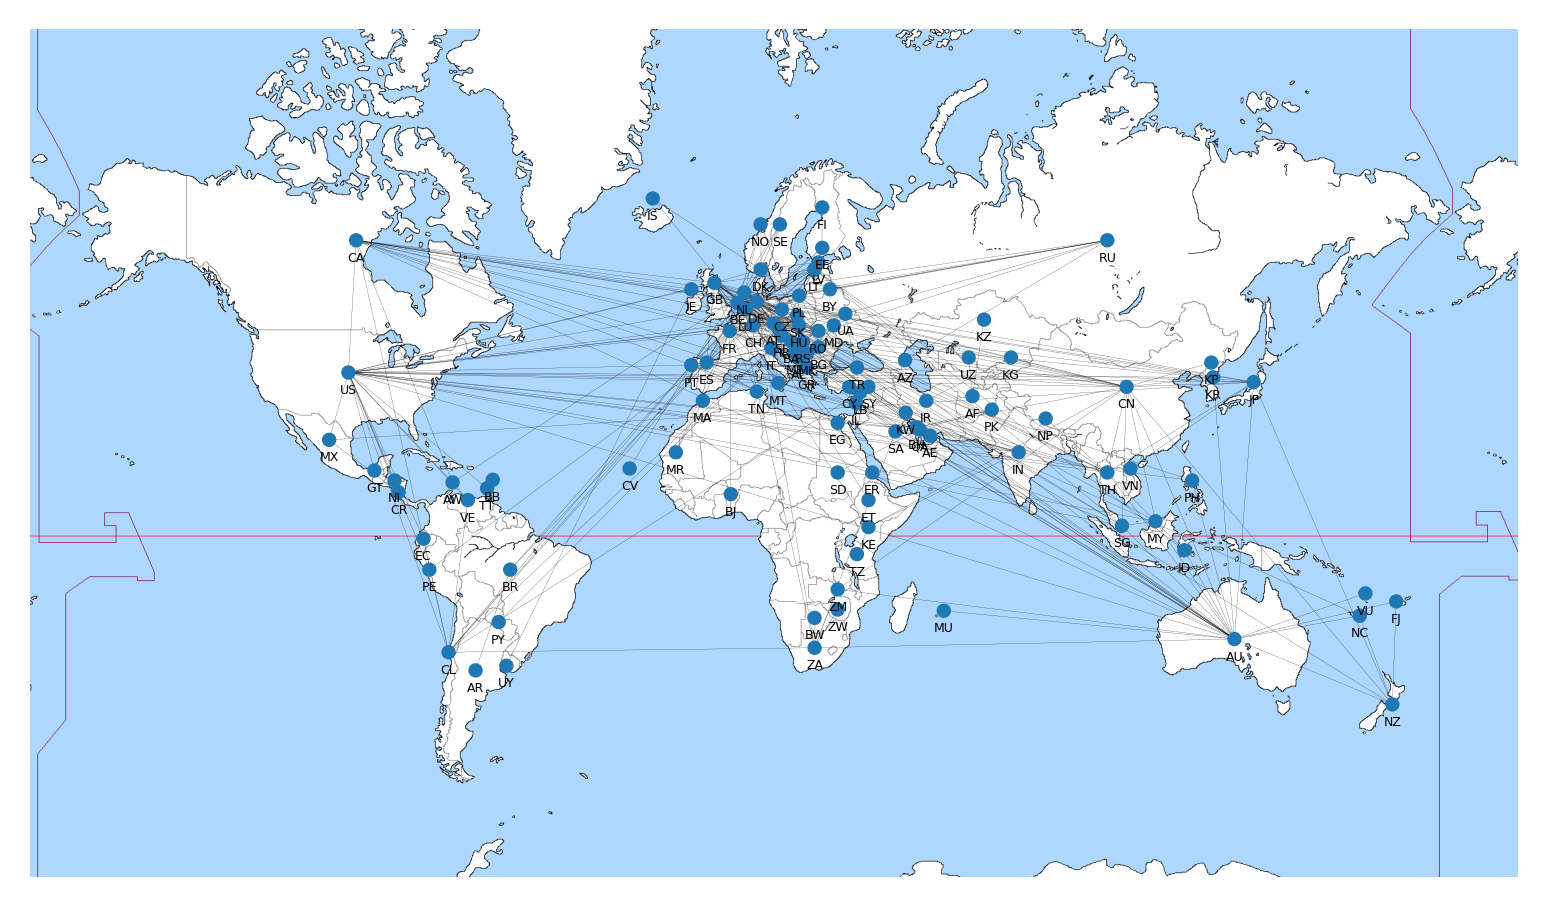

In [46]:
G, filtered_nodes, pos, codes = get_data(9, info=True)
draw(G, map=True)

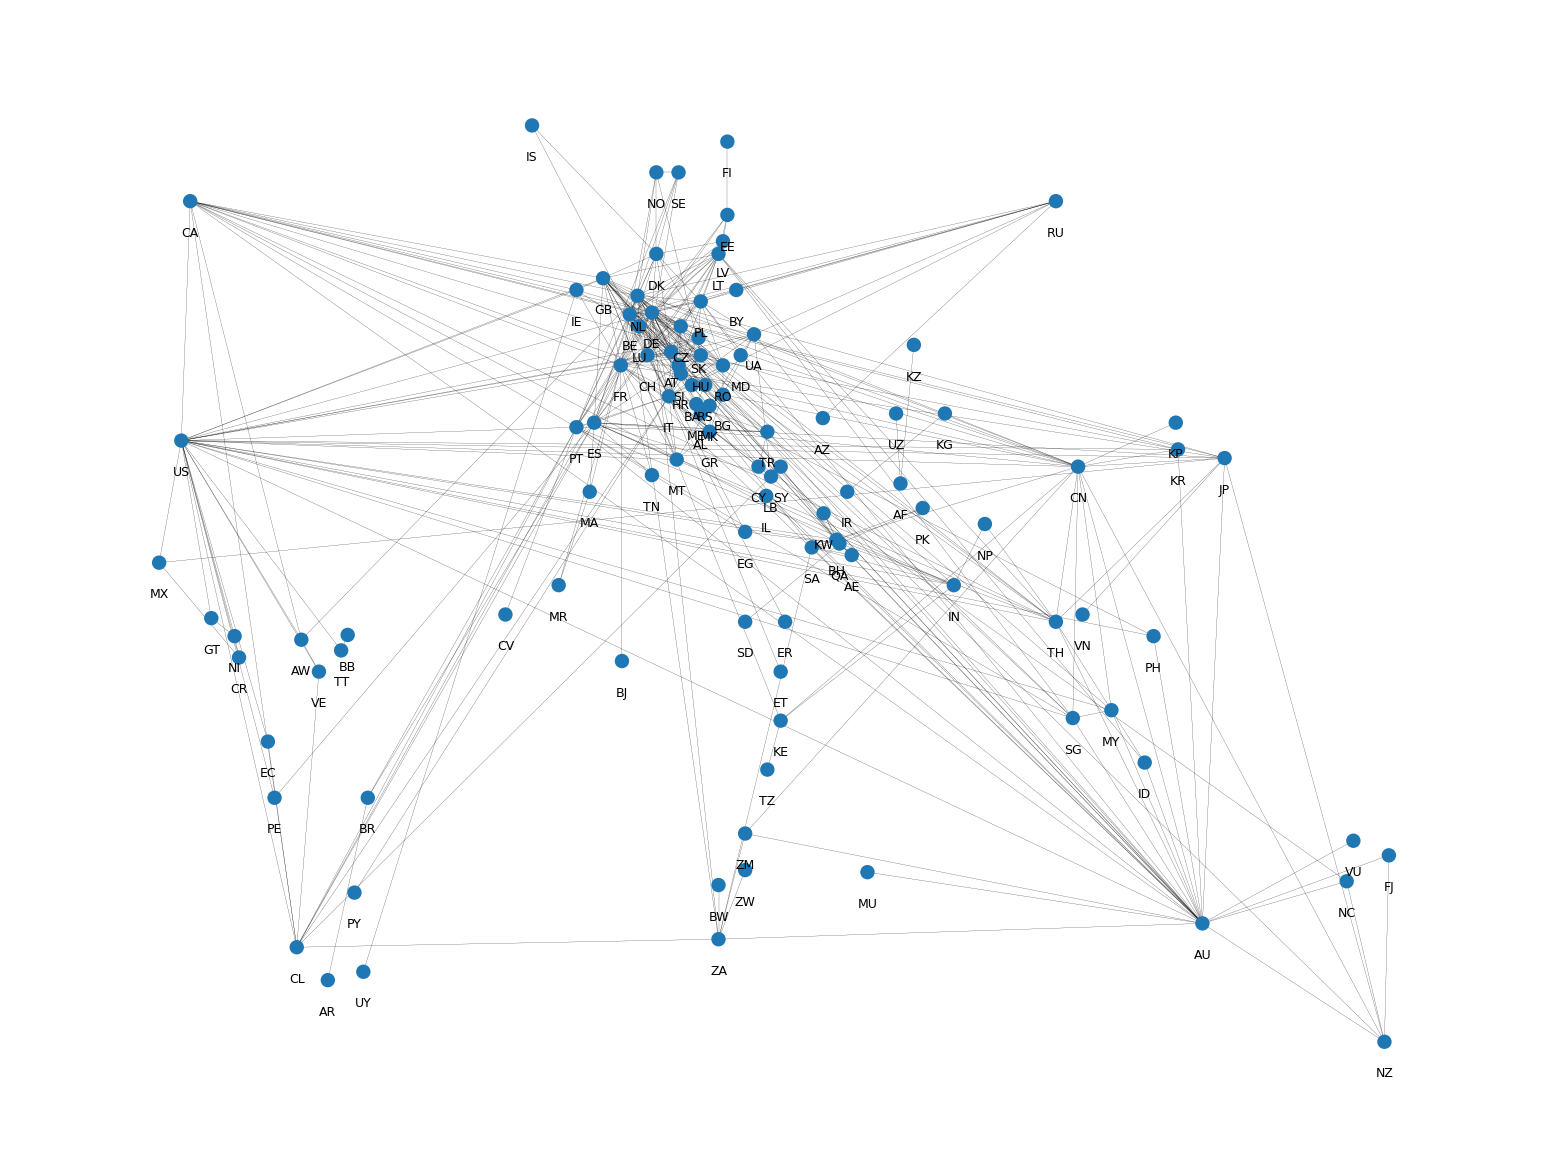

In [47]:
draw(G)

### Usando datos de imp/exp

In [48]:
imports = pd.read_csv(os.path.join(datapath, 'imports_by_country.csv'), index_col=0)
exports = pd.read_csv(os.path.join(datapath, 'exports_by_country.csv'), index_col=0)

# Left join A and B on 'name' column
merged_df = exports.merge(imports, on='name', how='left')

# Fill missing 'imports' with 0
merged_df['imports (m usd)'].fillna(0, inplace=True)

# Calculate the sum of 'exports' and 'imports' for each row
merged_df['i + e (m usd)'] = merged_df['exports (m usd)'] + merged_df['imports (m usd)']

# Select the columns you want to keep in the resulting dataframe (A)
total_trade = merged_df[['name', 'i + e (m usd)']]
total_trade.to_csv(os.path.join(datapath, 'total_trade_by_country.csv'), index=False)

### Posiciones reales -> gtg

In [55]:
def get_gtg(layer=1, theta=1e-3, resize='max', type='exports', join='add'):
    G, filtered_nodes, pos, codes = get_data(layer)

    # Lo mismo con los pesos. Matcheo la key de pos (indice de pais) con la tabla exports (o imp o total)
    if type == 'exports':
        weights = dict(zip(exports.index, exports['exports (m usd)']))
    elif type == 'imports':
        weights = dict(zip(imports.index, imports['imports (m usd)']))
    elif type == 'total':
        weights = dict(zip(total_trade.index, imports['i + e (m usd)']))
    
    if resize == 'max':
        sizes = {k : v / (.01 * max(list(weights.values()))) for k, v in weights.items()}
    else:
        sizes = {k : v / resize for k, v in weights.items()}

    # Me quedo solo con las posiciones de los nodos que aparecen en weights
    reduced_pos = {k: v for k, v in pos.items() if k in weights}
    reduced_pos = dict(enumerate(reduced_pos.values()))
    reindex_weights = dict(enumerate(weights.values()))
    reindex_sizes = dict(enumerate(sizes.values()))
    reindex_codes = dict(enumerate(codes.values()))

    gtg = enzope.geographical_threshold_graph_custom(len(reduced_pos.values()), theta=theta, pos=reduced_pos, weight=reindex_weights, join=join)
    nx.set_node_attributes(gtg, reindex_codes, 'code')
    nx.set_node_attributes(gtg, reindex_sizes, 'size')
    return gtg

In [56]:
gtg = get_gtg(9, theta=2e-3)
# nx.connectivity.average_node_connectivity(gtg), nx.connectivity.average_node_connectivity(G)

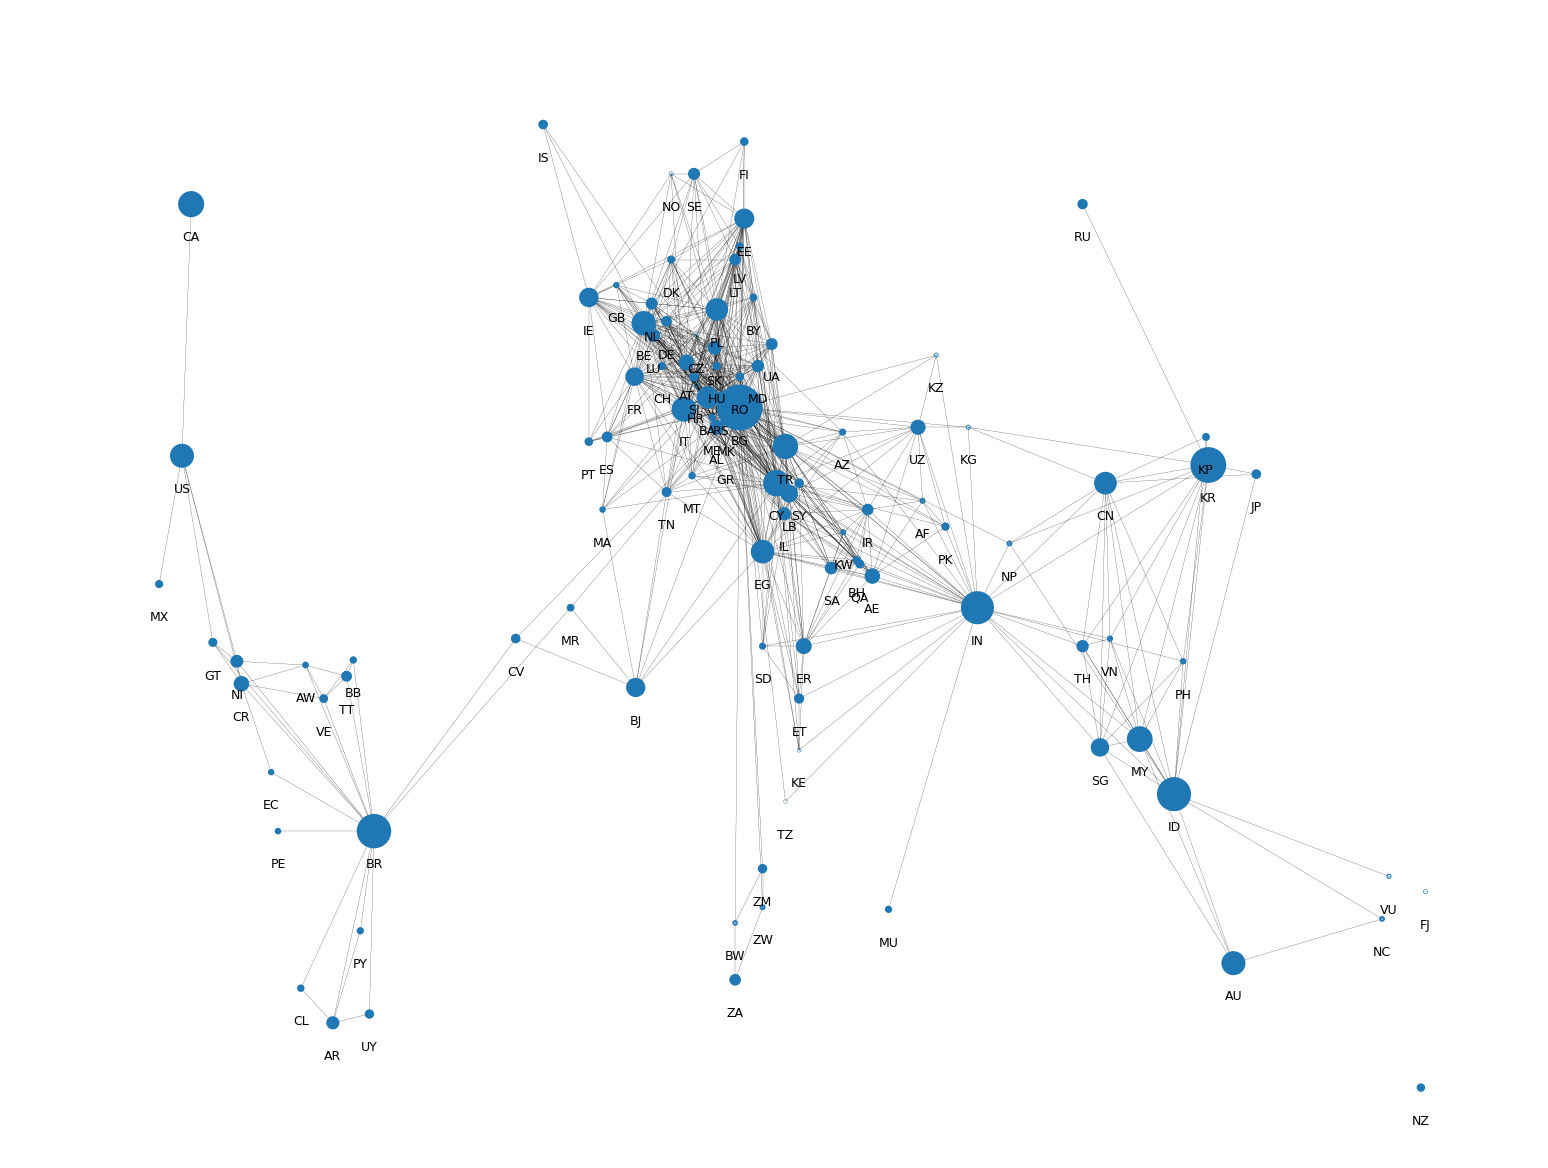

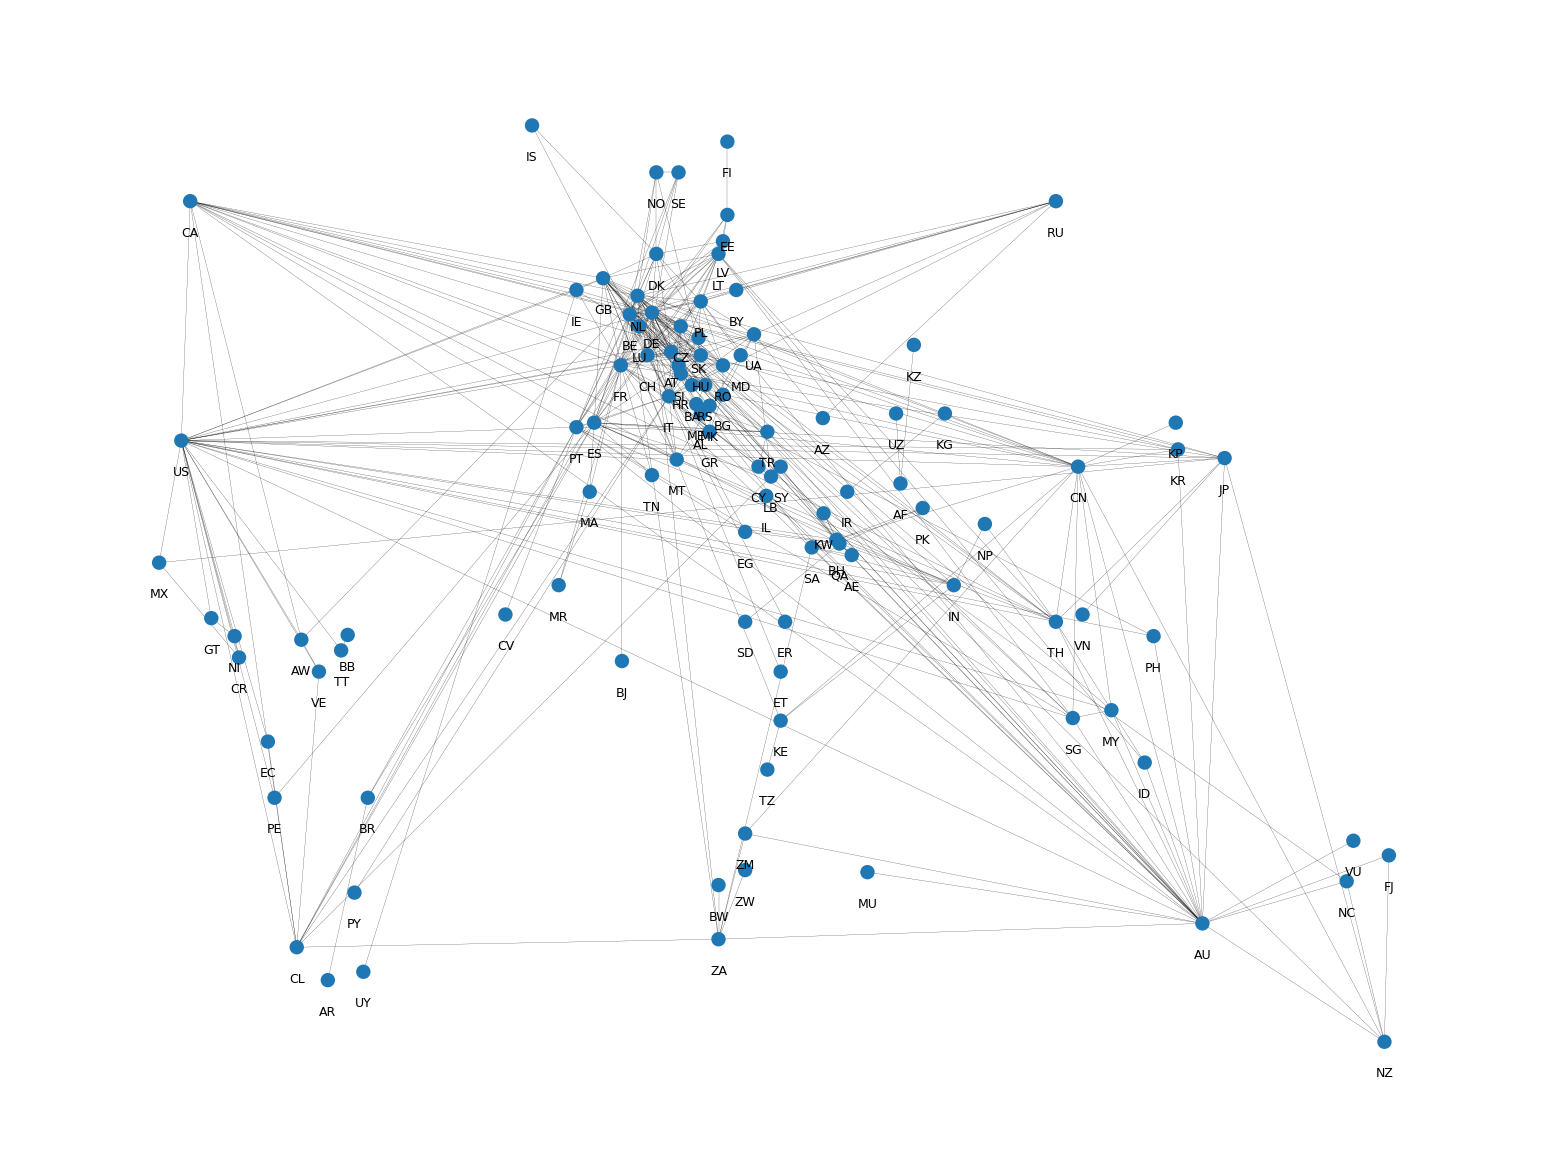

In [57]:
draw(gtg)
draw(G)

## 10/10: Redes gtg con peso sacado de los datos

### Empecemos con las 6 redes para todos los paises (E, I, E+I) (add y mul)

In [17]:
theta = 7e-3

nodes = pd.read_csv(os.path.join(datapath, 'nodes-merged.csv'))

pos = {node : [nodes.loc[nodes['index'] == node, 'x'].values[0], nodes.loc[nodes['index'] == node, 'y'].values[0]] for node in nodes['index']}
codes = {node : nodes.loc[nodes['index'] == node, 'Code'].values[0] for node in nodes['index']}

reindex_pos = dict(enumerate(pos.values()))
reindex_codes = dict(enumerate(codes.values()))

exp_weights = dict(zip(exports.index, exports['exports (m usd)']))
imp_weights = dict(zip(imports.index, imports['imports (m usd)']))
act_weights = dict(zip(total_trade.index, total_trade['i + e (m usd)']))

exp_sizes = {k : v / (.01*max(list(exp_weights.values()))) for k, v in exp_weights.items()}
imp_sizes = {k : v / (.01*max(list(imp_weights.values()))) for k, v in imp_weights.items()}
act_sizes = {k : v / (.01*max(list(act_weights.values()))) for k, v in act_weights.items()}

exp_pos = {k: v for k, v in pos.items() if k in exp_weights}
imp_pos = {k: v for k, v in pos.items() if k in imp_weights}
act_pos = {k: v for k, v in pos.items() if k in act_weights}

# Esto es horrible pero reindexo los diccionarios para que los entienda el grafo (tienen que ser 1, 2, 3 sin saltearse)
exp_weights = dict(enumerate(exp_weights.values()))
exp_sizes = dict(enumerate(exp_sizes.values()))
exp_pos = dict(enumerate(exp_pos.values()))
imp_weights = dict(enumerate(imp_weights.values()))
imp_sizes = dict(enumerate(imp_sizes.values()))
imp_pos = dict(enumerate(imp_pos.values()))
act_weights = dict(enumerate(act_weights.values()))
act_sizes = dict(enumerate(act_sizes.values()))
act_pos = dict(enumerate(act_pos.values()))

# Exp add
gtg1 = enzope.geographical_threshold_graph_custom(len(exp_pos.values()), theta=theta, pos=exp_pos, weight=exp_weights, join='add')
nx.set_node_attributes(gtg1, reindex_codes, 'code')
nx.set_node_attributes(gtg1, exp_sizes, 'size')

# Imp add
gtg2 = enzope.geographical_threshold_graph_custom(len(imp_pos.values()), theta=theta, pos=imp_pos, weight=imp_weights, join='add')
nx.set_node_attributes(gtg2, reindex_codes, 'code')
nx.set_node_attributes(gtg2, imp_sizes, 'size')

# Act add
gtg3 = enzope.geographical_threshold_graph_custom(len(act_pos.values()), theta=theta, pos=act_pos, weight=act_weights, join='add')
nx.set_node_attributes(gtg3, reindex_codes, 'code')
nx.set_node_attributes(gtg3, act_sizes, 'size')

# Exp mul
gtg4 = enzope.geographical_threshold_graph_custom(len(exp_pos.values()), theta=1000*theta, pos=exp_pos, weight=exp_weights, join='mul')
nx.set_node_attributes(gtg4, reindex_codes, 'code')
nx.set_node_attributes(gtg4, exp_sizes, 'size')

# Imp mul
gtg5 = enzope.geographical_threshold_graph_custom(len(imp_pos.values()), theta=1000*theta, pos=imp_pos, weight=imp_weights, join='mul')
nx.set_node_attributes(gtg5, reindex_codes, 'code')
nx.set_node_attributes(gtg5, imp_sizes, 'size')

# Act mul
gtg6 = enzope.geographical_threshold_graph_custom(len(act_pos.values()), theta=1000*theta, pos=act_pos, weight=act_weights, join='mul')
nx.set_node_attributes(gtg6, reindex_codes, 'code')
nx.set_node_attributes(gtg6, act_sizes, 'size')


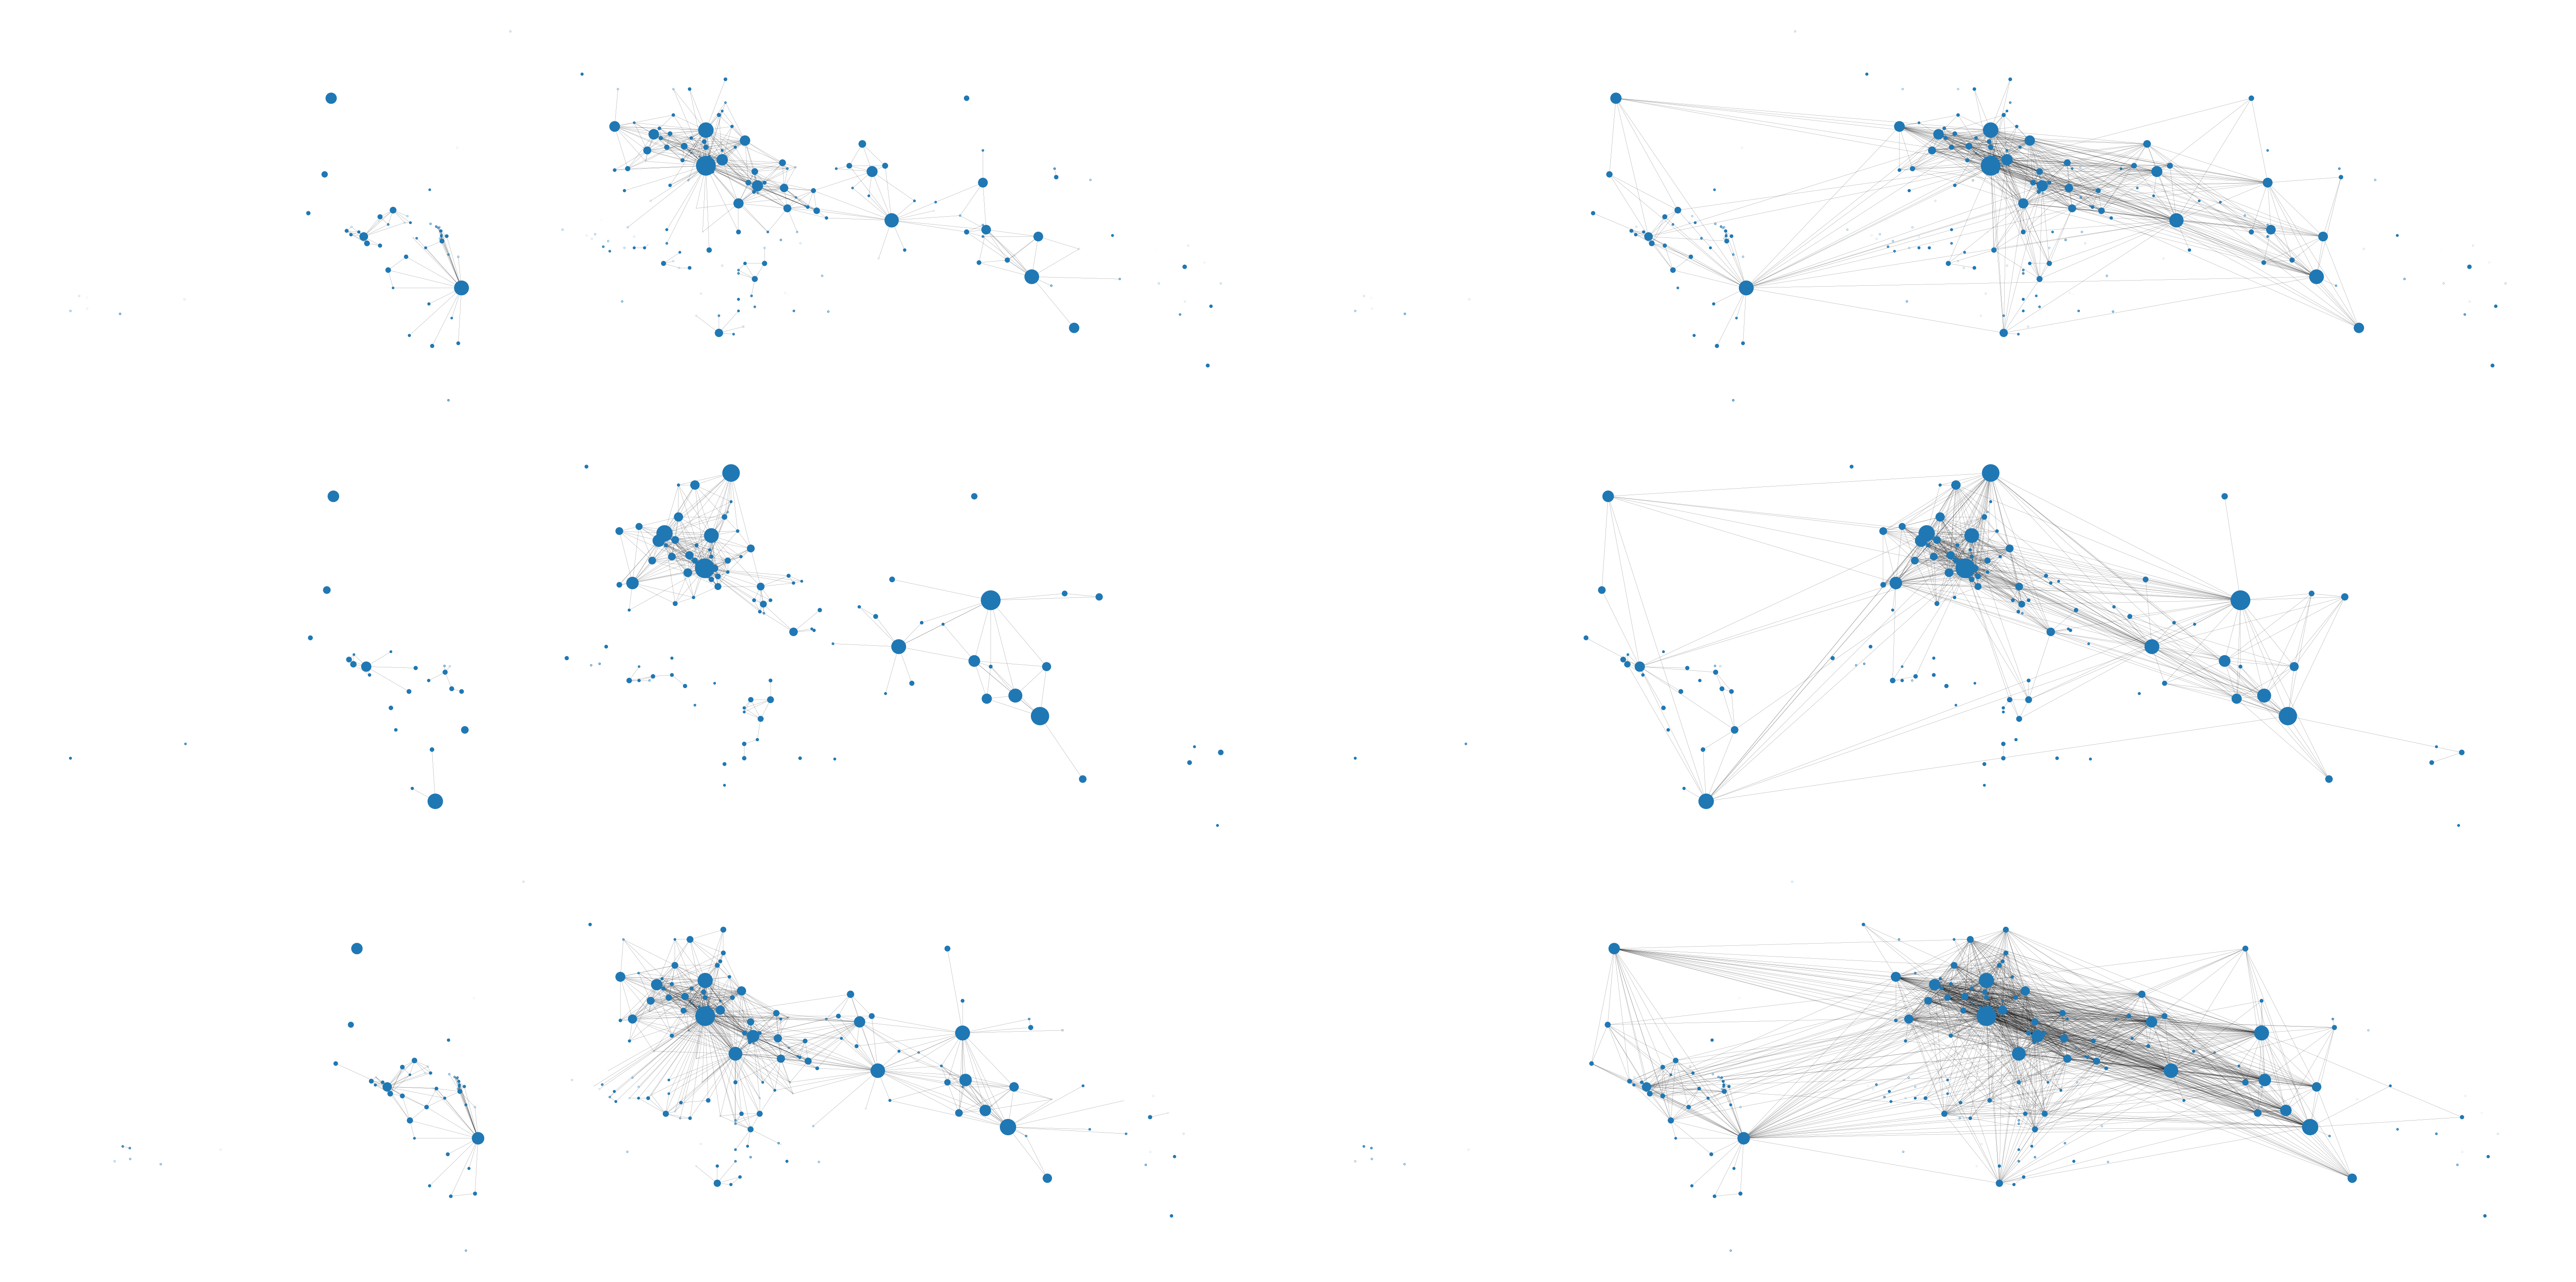

In [36]:
graphs = [gtg1, gtg2, gtg3, gtg4, gtg5, gtg6]  # Replace with your actual graph objects

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=[20, 10], dpi=300)

# Iterate through the graphs and corresponding subplot axes
for i, graph in enumerate(graphs):
    row = i % 3  # Calculate the row index (0 or 1)
    col = i // 3   # Calculate the column index (0, 1, or 2)
    ax = axs[row, col]  # Get the appropriate subplot axis

    # Call your draw function for the current graph and subplot axis
    draw(graph, show_labels=False, ax=ax)

# Adjust the layout to prevent overlap
plt.tight_layout()

plt.savefig('test.png', dpi=300)

# Display the plot
plt.show()


Text(0.5, 1.0, 'Exp add')

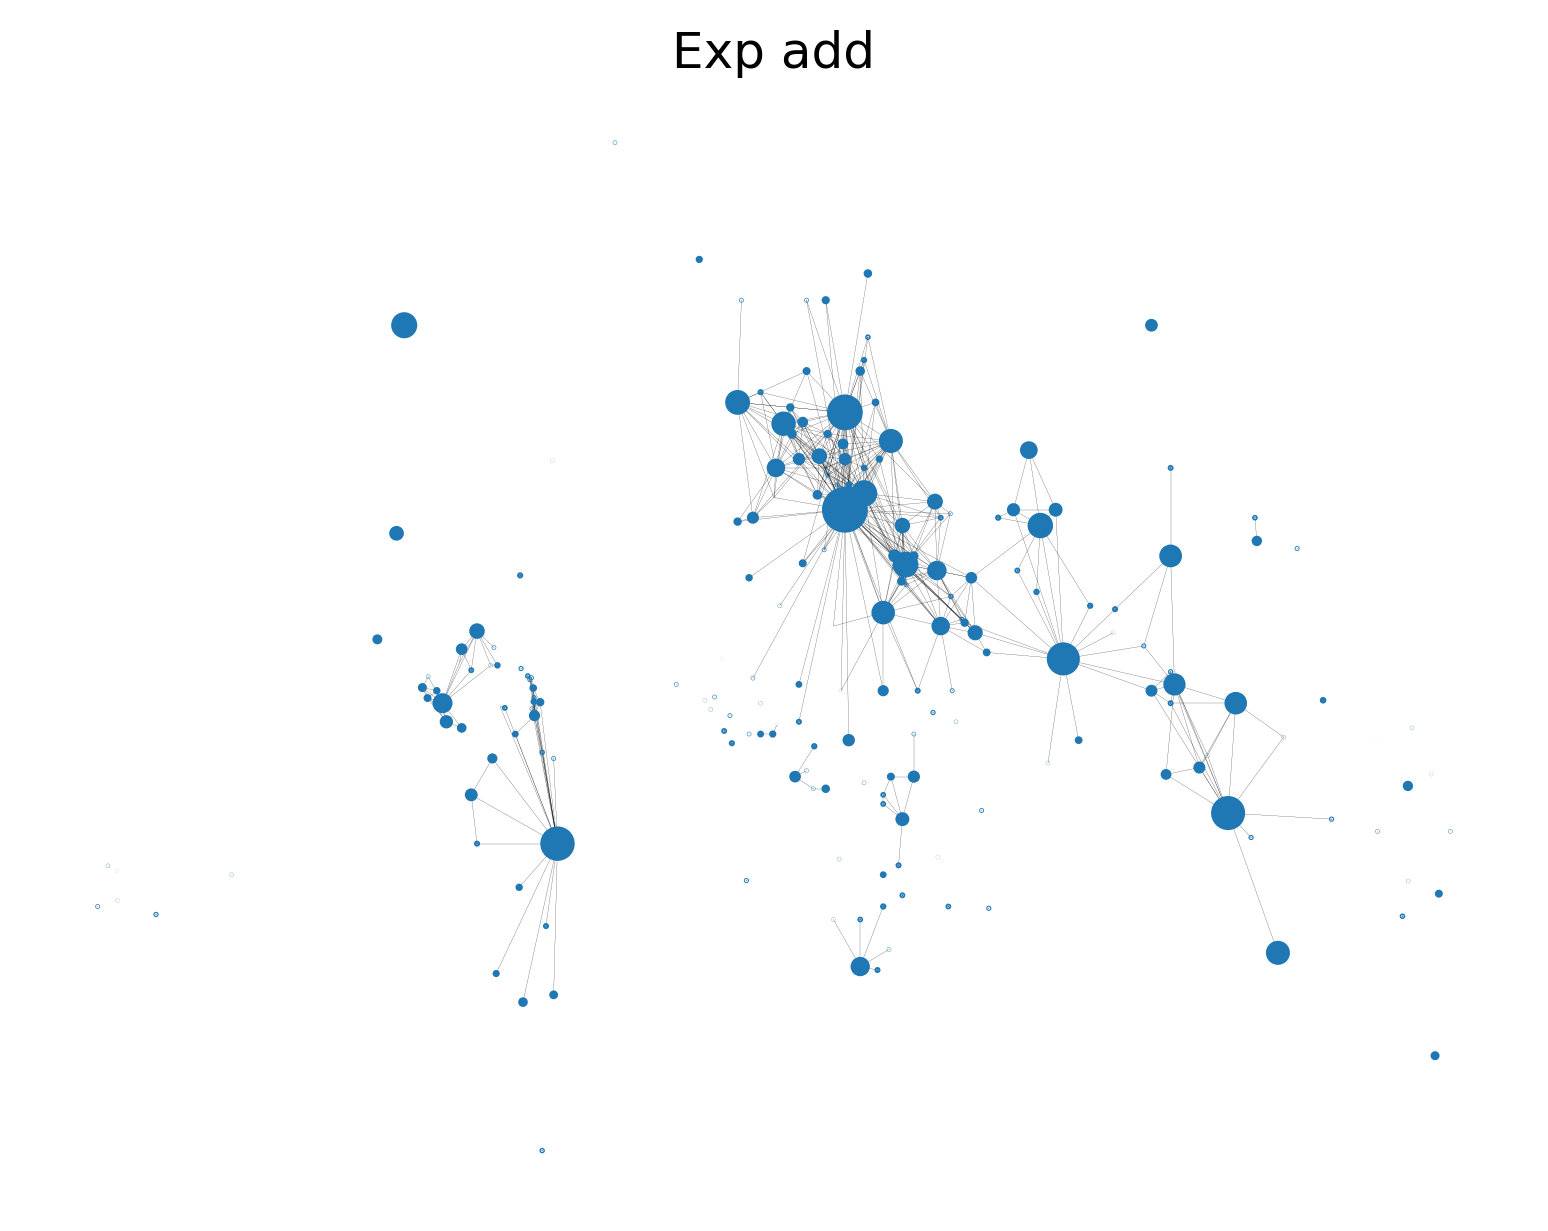

In [38]:
fig, ax = plt.subplots(dpi=300)
draw(gtg1, ax=ax, show_labels=False)
ax.set_title('Exp add')